# KneeMRI Dataset

# DarkNet

Using device: cuda
Starting Fold 1/7
Epoch [1/20]
Train Loss: 0.6919, Train Accu: 75.03% Test Loss: 0.5854, Test Accu: 79.34% val Loss: 0.7020, val Accu: 74.49% Prec: 0.7992, Recall: 0.7449, F1: 0.7248 AUC: 0.8992, Kappa: 0.5976 Sens: 0.7500, Spec: 0.8660 Dice Coeff: 0.6503 RMSE: 0.6217, MAE: 0.2989, MSE: 0.3865 PPV: 0.5741
Epoch [2/20]
Train Loss: 1.1811, Train Accu: 57.22% Test Loss: 0.9810, Test Accu: 63.75% val Loss: 1.1157, val Accu: 59.78% Prec: 0.6058, Recall: 0.5978, F1: 0.5407 AUC: 0.7565, Kappa: 0.3990 Sens: 0.7823, Spec: 0.6641 Dice Coeff: 0.4924 RMSE: 0.7110, MAE: 0.4366, MSE: 0.5055 PPV: 0.3593
Epoch [3/20]
Train Loss: 0.6163, Train Accu: 78.82% Test Loss: 0.6741, Test Accu: 73.89% val Loss: 0.6087, val Accu: 79.03% Prec: 0.8104, Recall: 0.7903, F1: 0.7779 AUC: 0.9179, Kappa: 0.6551 Sens: 0.4839, Spec: 0.9942 Dice Coeff: 0.6417 RMSE: 0.5719, MAE: 0.2488, MSE: 0.3271 PPV: 0.9524
Epoch [4/20]
Train Loss: 0.8670, Train Accu: 69.65% Test Loss: 1.1959, Test Accu: 57.41% val Los

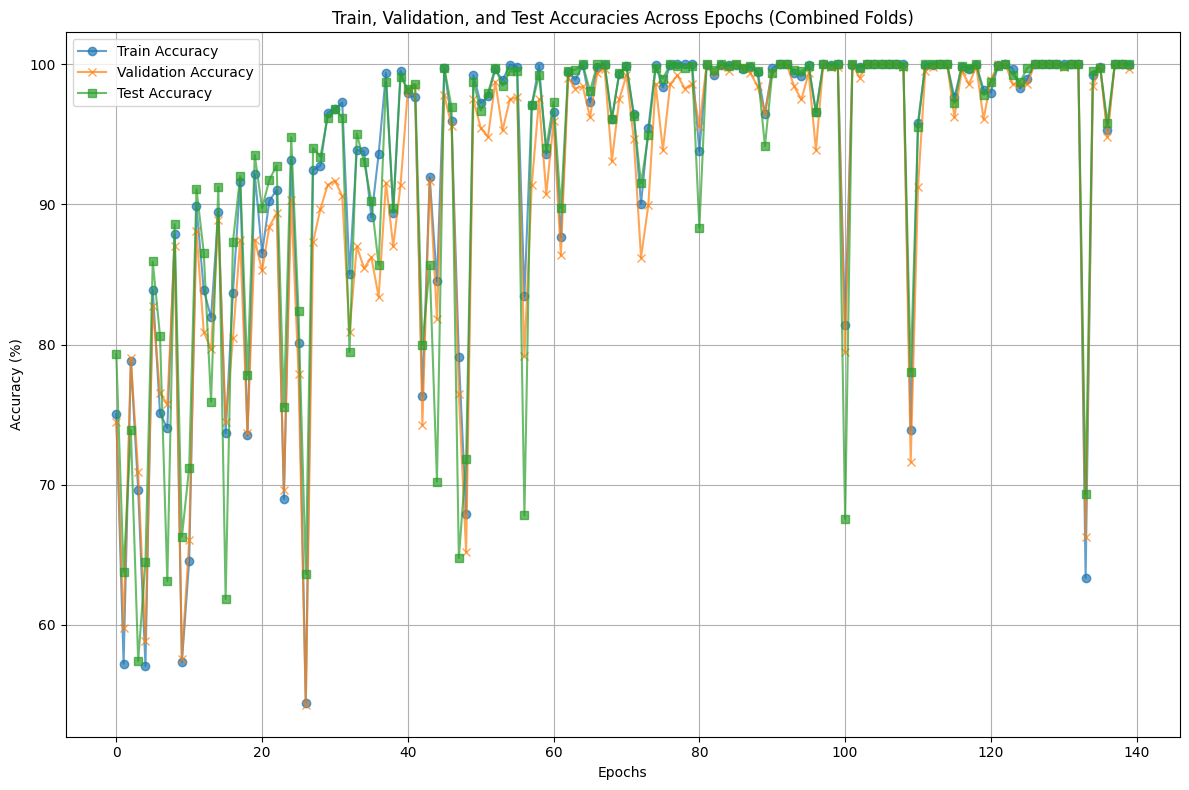

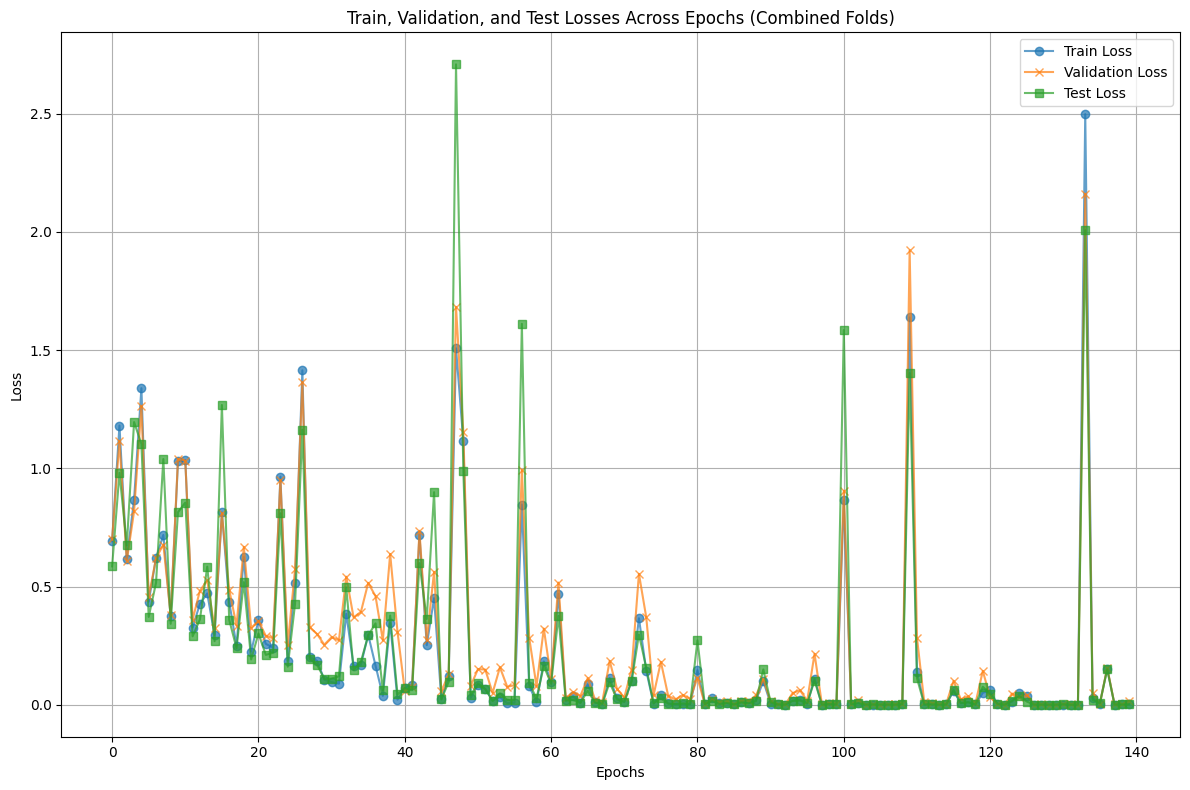

In [2]:
import os
import torch
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import cohen_kappa_score, roc_curve, auc
import numpy as np

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the custom dataset class
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for label in sorted(os.listdir(root_dir)):
            label_dir = os.path.join(root_dir, label)
            if os.path.isdir(label_dir):
                for img_name in os.listdir(label_dir):
                    if img_name.endswith('.jpg') or img_name.endswith('.png'):
                        img_path = os.path.join(label_dir, img_name)
                        self.image_paths.append(img_path)
                        self.labels.append(int(label))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('L')  # Ensure grayscale image loading
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Transformations to apply to the images
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to 256x256
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalization for grayscale
])

# Load dataset
data_dir = 'new dataf'
full_dataset = CustomDataset(root_dir=data_dir, transform=transform)
train_size = int(0.85 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

# Define the CNN model (already provided)
class Conv(nn.Module):
    """Standard Convolutional Block"""

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int = 1,
        stride: int = 1,
        padding: int = None,
        groups: int = 1,
        dilation: int = 1,
        inplace: bool = True,
        bias: bool = False,
    ) -> None:
        super().__init__()

        if padding is None:
            padding = kernel_size // 2

        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            dilation=dilation,
            groups=groups,
            bias=bias,
        )
        self.norm = nn.BatchNorm2d(num_features=out_channels)
        self.act = nn.LeakyReLU(0.01, inplace=inplace)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        x = self.norm(x)
        x = self.act(x)
        return x

class GlobalAvgPool2d(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.mean(x.view(x.size(0), x.size(1), -1), dim=2)


def _initialize_weights(module):
    """Initialize the weights of convolutional, batch normalization, and linear layers"""

    if isinstance(module, nn.Conv2d):
        nn.init.kaiming_normal_(module.weight, mode='fan_in', nonlinearity='leaky_relu')
        if module.bias is not None:
            nn.init.constant_(module.bias, 0)
    elif isinstance(module, nn.BatchNorm2d):
        nn.init.constant_(module.weight, 1)
        nn.init.constant_(module.bias, 0)
    elif isinstance(module, nn.Linear):
        nn.init.normal_(module.weight, 0, 0.01)
        nn.init.constant_(module.bias, 0)

class DarkNet19(nn.Module):
    """DarkNet19 <https://arxiv.org/pdf/1612.08242.pdf>"""

    def __init__(self, num_classes: int = 1000, init_weight: bool = True) -> None:
        super().__init__()

        if init_weight:
            self.apply(_initialize_weights)

        self.features = nn.Sequential(
            Conv(in_channels=1, out_channels=32, kernel_size=3),
            nn.MaxPool2d(kernel_size=2, stride=2),

            Conv(in_channels=32, out_channels=64, kernel_size=3),
            nn.MaxPool2d(kernel_size=2, stride=2),

            Conv(in_channels=64, out_channels=128, kernel_size=3),
            Conv(in_channels=128, out_channels=64, kernel_size=1),
            Conv(in_channels=64, out_channels=128, kernel_size=3),
            nn.MaxPool2d(kernel_size=2, stride=2),

            Conv(in_channels=128, out_channels=256, kernel_size=3),
            Conv(in_channels=256, out_channels=128, kernel_size=1),
            Conv(in_channels=128, out_channels=256, kernel_size=3),
            nn.MaxPool2d(kernel_size=2, stride=2),

            Conv(in_channels=256, out_channels=512, kernel_size=3),
            Conv(in_channels=512, out_channels=256, kernel_size=1),
            Conv(in_channels=256, out_channels=512, kernel_size=3),
            Conv(in_channels=512, out_channels=256, kernel_size=1),
            Conv(in_channels=256, out_channels=512, kernel_size=3),
            nn.MaxPool2d(kernel_size=2, stride=2),

            Conv(in_channels=512, out_channels=1024, kernel_size=3),
            Conv(in_channels=1024, out_channels=512, kernel_size=1),
            Conv(in_channels=512, out_channels=1024, kernel_size=3),
            Conv(in_channels=1024, out_channels=512, kernel_size=1),
            Conv(in_channels=512, out_channels=1024, kernel_size=3),
        )

        self.classifier = nn.Sequential(
            *self.features,
            Conv(in_channels=1024, out_channels=num_classes, kernel_size=1),
            GlobalAvgPool2d()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.classifier(x)
        return out

model = DarkNet19(num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

from sklearn.metrics import confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, cohen_kappa_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score

def evaluate_metrics(loader, model, criterion, device):
    model.eval()
    val_loss = 0.0
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            probs = F.softmax(outputs, dim=1).cpu().numpy()  # Probabilities for AUC
            preds = torch.argmax(outputs, dim=1).cpu().numpy()    # Predicted classes
            labels = labels.cpu().numpy()

            all_labels.extend(labels)
            all_preds.extend(preds)
            all_probs.extend(probs)

    # Convert to numpy arrays
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    # Calculate metrics
     # Calculate metrics
    binary_labels = (all_labels == 2).astype(int)
    binary_preds = (all_preds == 2).astype(int)
    cm = confusion_matrix(binary_labels, binary_preds)
    
    
    # Handle multi-class confusion matrix 
    accuracy = accuracy_score(all_labels, all_preds)*100
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    # If binary classification calculate below metrics or use suitable multi-class metrics
    tn, fp, fn, tp = cm.ravel()
    auc = roc_auc_score(all_labels, all_probs, multi_class='ovr')  # Use the probabilities for the positive class
    kappa = cohen_kappa_score(all_labels, all_preds)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    dice = (2 * tp) / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0

    rmse = np.sqrt(mean_squared_error(all_labels, all_preds))
    mae = mean_absolute_error(all_labels, all_preds)
    mse = mean_squared_error(all_labels, all_preds)

    metrics = {
        'Loss': val_loss / len(loader),
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC': auc,
        'Kappa': kappa,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'Dice Coefficient': dice,
        'RMSE': rmse,
        'MAE': mae,
        'MSE': mse,
        'PPV': ppv
    }

    return metrics


last_epoch_train_losses = []
last_epoch_train_accuracies = []
last_epoch_val_metrics = {
    'Loss': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': [],
    'AUC': [],
    'Kappa': [],
    'Sensitivity': [],
    'Specificity': [],
    'Dice Coefficient': [],
    'RMSE': [],
    'MAE': [],
    'MSE': [],
    'PPV': []
}

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []

# K-Fold Cross-Validation
k_folds = 7
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
fold_results = []

for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):
    print(f"Starting Fold {fold + 1}/{k_folds}")
    
    # Subset datasets
    train_subset = Subset(full_dataset, train_idx)
    val_subset = Subset(full_dataset, val_idx)
    trainsub_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
    num_epochs = 20
    
    for epoch in range(20):  # Use smaller epochs for debugging; increase for full training
        model.train()
        running_loss = 0.0
        for images, labels in trainsub_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        
        train_metrics = evaluate_metrics(trainsub_loader, model, criterion, device)
        val_metrics = evaluate_metrics(val_loader, model, criterion, device)
        test_metrics = evaluate_metrics(test_loader, model, criterion, device)

        train_losses.append(train_metrics['Loss'])
        train_accuracies.append(train_metrics['Accuracy'])
        val_losses.append(val_metrics['Loss'])
        val_accuracies.append(val_metrics['Accuracy'])
        test_losses.append(test_metrics['Loss'])
        test_accuracies.append(test_metrics['Accuracy'])

        if epoch == num_epochs - 1:
            last_epoch_train_losses.append(running_loss / len(train_loader))
            last_epoch_train_accuracies.append(train_metrics['Accuracy'])
            for key in last_epoch_val_metrics:
                last_epoch_val_metrics[key].append(val_metrics[key])

        # Print metrics
        print(f"Epoch [{epoch + 1}/{num_epochs}]")
        print(f"Train Loss: {train_metrics['Loss']:.4f}, Train Accu: {train_metrics['Accuracy']:.2f}%",
            f"Test Loss: {test_metrics['Loss']:.4f}, Test Accu: {test_metrics['Accuracy']:.2f}%",
            f"val Loss: {val_metrics['Loss']:.4f}, val Accu: {val_metrics['Accuracy']:.2f}%",
            f"Prec: {val_metrics['Precision']:.4f}, Recall: {val_metrics['Recall']:.4f}, "
            f"F1: {val_metrics['F1 Score']:.4f}",
            f"AUC: {val_metrics['AUC']:.4f}, Kappa: {val_metrics['Kappa']:.4f}",
            f"Sens: {val_metrics['Sensitivity']:.4f}, Spec: {val_metrics['Specificity']:.4f}",
            f"Dice Coeff: {val_metrics['Dice Coefficient']:.4f}",
            f"RMSE: {val_metrics['RMSE']:.4f}, MAE: {val_metrics['MAE']:.4f}, MSE: {val_metrics['MSE']:.4f}",
            f"PPV: {val_metrics['PPV']:.4f}")


avg_train_loss = np.mean(last_epoch_train_losses)
avg_train_accuracy = np.mean(last_epoch_train_accuracies)
avg_val_metrics = {key: np.mean(values) for key, values in last_epoch_val_metrics.items()}

# Print average metrics
print(f"Average Train Loss: {avg_train_loss:.4f}")
print(f"Average Train Accuracy: {avg_train_accuracy:.2f}%")
print("Average Validation Metrics:")
for key, value in avg_val_metrics.items():
    print(f"{key}: {value:.4f}")

import matplotlib.pyplot as plt

# After your training loop and evaluation, you can plot all metrics

# Plot Train, Validation, and Test Accuracy
plt.figure(figsize=(12, 8))
plt.plot(np.arange(len(train_accuracies)), train_accuracies, label='Train Accuracy', linestyle='-', marker='o', alpha=0.7)
plt.plot(np.arange(len(val_accuracies)), val_accuracies, label='Validation Accuracy', linestyle='-', marker='x', alpha=0.7)
plt.plot(np.arange(len(test_accuracies)), test_accuracies, label='Test Accuracy', linestyle='-', marker='s', alpha=0.7)
plt.title('Train, Validation, and Test Accuracies Across Epochs (Combined Folds)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Train, Validation, and Test Losses
plt.figure(figsize=(12, 8))
plt.plot(np.arange(len(train_losses)), train_losses, label='Train Loss', linestyle='-', marker='o', alpha=0.7)
plt.plot(np.arange(len(val_losses)), val_losses, label='Validation Loss', linestyle='-', marker='x', alpha=0.7)
plt.plot(np.arange(len(test_losses)), test_losses, label='Test Loss', linestyle='-', marker='s', alpha=0.7)
plt.title('Train, Validation, and Test Losses Across Epochs (Combined Folds)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

# MobileNet

In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import cohen_kappa_score, roc_curve, auc
import numpy as np

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the custom dataset class
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for label in sorted(os.listdir(root_dir)):
            label_dir = os.path.join(root_dir, label)
            if os.path.isdir(label_dir):
                for img_name in os.listdir(label_dir):
                    if img_name.endswith('.jpg') or img_name.endswith('.png'):
                        img_path = os.path.join(label_dir, img_name)
                        self.image_paths.append(img_path)
                        self.labels.append(int(label))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('L')  # Ensure grayscale image loading
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Transformations to apply to the images
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to 256x256
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalization for grayscale
])

# Load dataset
data_dir = 'new dataf'
full_dataset = CustomDataset(root_dir=data_dir, transform=transform)
train_size = int(0.85 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)
# Define the CNN model (already provided)

class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=stride, padding=1, groups=in_channels, bias=False)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.bn(x)
        return F.relu(x)

class MobileNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(MobileNet, self).__init__()

        # Initial Conv layer adapted for grayscale input (1-channel)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)  # 1-channel input
        self.bn1 = nn.BatchNorm2d(32)

        # Define MobileNet blocks
        self.blocks = nn.Sequential(
            DepthwiseSeparableConv(32, 64, stride=1),
            DepthwiseSeparableConv(64, 128, stride=2),
            DepthwiseSeparableConv(128, 128, stride=1),
            DepthwiseSeparableConv(128, 256, stride=2),
            DepthwiseSeparableConv(256, 256, stride=1),
            DepthwiseSeparableConv(256, 512, stride=2),
            *[DepthwiseSeparableConv(512, 512, stride=1) for _ in range(5)],
            DepthwiseSeparableConv(512, 1024, stride=2),
            DepthwiseSeparableConv(1024, 1024, stride=1)
        )

        # Average pooling and fully connected layer for classification
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        # Initial convolution layer
        x = F.relu(self.bn1(self.conv1(x)))

        # MobileNet blocks
        x = self.blocks(x)

        # Global Average Pooling and fully connected layer
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

model = MobileNet(num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

from sklearn.metrics import confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, cohen_kappa_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score

def evaluate_metrics(loader, model, criterion, device):
    model.eval()
    val_loss = 0.0
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            probs = F.softmax(outputs, dim=1).cpu().numpy()  # Probabilities for AUC
            preds = torch.argmax(outputs, dim=1).cpu().numpy()    # Predicted classes
            labels = labels.cpu().numpy()

            all_labels.extend(labels)
            all_preds.extend(preds)
            all_probs.extend(probs)

    # Convert to numpy arrays
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    # Calculate metrics
     # Calculate metrics
    binary_labels = (all_labels == 2).astype(int)
    binary_preds = (all_preds == 2).astype(int)
    cm = confusion_matrix(binary_labels, binary_preds)
    
    
    # Handle multi-class confusion matrix 
    accuracy = accuracy_score(all_labels, all_preds)*100
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    # If binary classification calculate below metrics or use suitable multi-class metrics
    tn, fp, fn, tp = cm.ravel()
    auc = roc_auc_score(all_labels, all_probs, multi_class='ovr')  # Use the probabilities for the positive class
    kappa = cohen_kappa_score(all_labels, all_preds)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    dice = (2 * tp) / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0

    rmse = np.sqrt(mean_squared_error(all_labels, all_preds))
    mae = mean_absolute_error(all_labels, all_preds)
    mse = mean_squared_error(all_labels, all_preds)

    metrics = {
        'Loss': val_loss / len(loader),
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC': auc,
        'Kappa': kappa,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'Dice Coefficient': dice,
        'RMSE': rmse,
        'MAE': mae,
        'MSE': mse,
        'PPV': ppv
    }

    return metrics

last_epoch_train_losses = []
last_epoch_train_accuracies = []
last_epoch_val_metrics = {
    'Loss': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': [],
    'AUC': [],
    'Kappa': [],
    'Sensitivity': [],
    'Specificity': [],
    'Dice Coefficient': [],
    'RMSE': [],
    'MAE': [],
    'MSE': [],
    'PPV': []
}

# K-Fold Cross-Validation
k_folds = 7
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
fold_results = []

for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):
    print(f"Starting Fold {fold + 1}/{k_folds}")
    
    # Subset datasets
    train_subset = Subset(full_dataset, train_idx)
    val_subset = Subset(full_dataset, val_idx)
    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
    num_epochs = 20
    
    for epoch in range(20):  # Use smaller epochs for debugging; increase for full training
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        
        train_metrics = evaluate_metrics(train_loader, model, criterion, device)
        val_metrics = evaluate_metrics(val_loader, model, criterion, device)

        if epoch == num_epochs - 1:
            last_epoch_train_losses.append(running_loss / len(train_loader))
            last_epoch_train_accuracies.append(train_metrics['Accuracy'])
            for key in last_epoch_val_metrics:
                last_epoch_val_metrics[key].append(val_metrics[key])

        # Print metrics
        print(f"Epoch [{epoch + 1}/{num_epochs}]")
        print(f"Train Loss: {train_metrics['Loss']:.4f}, Train Accu: {train_metrics['Accuracy']:.2f}%",
            f"val Loss: {val_metrics['Loss']:.4f}, val Accu: {val_metrics['Accuracy']:.2f}%",
            f"Prec: {val_metrics['Precision']:.4f}, Recall: {val_metrics['Recall']:.4f}, "
            f"F1: {val_metrics['F1 Score']:.4f}",
            f"AUC: {val_metrics['AUC']:.4f}, Kappa: {val_metrics['Kappa']:.4f}",
            f"Sens: {val_metrics['Sensitivity']:.4f}, Spec: {val_metrics['Specificity']:.4f}",
            f"Dice Coeff: {val_metrics['Dice Coefficient']:.4f}",
            f"RMSE: {val_metrics['RMSE']:.4f}, MAE: {val_metrics['MAE']:.4f}, MSE: {val_metrics['MSE']:.4f}",
            f"PPV: {val_metrics['PPV']:.4f}")

avg_train_loss = np.mean(last_epoch_train_losses)
avg_train_accuracy = np.mean(last_epoch_train_accuracies)
avg_val_metrics = {key: np.mean(values) for key, values in last_epoch_val_metrics.items()}

# Print average metrics
print(f"Average Train Loss: {avg_train_loss:.4f}")
print(f"Average Train Accuracy: {avg_train_accuracy:.2f}%")
print("Average Validation Metrics:")
for key, value in avg_val_metrics.items():
    print(f"{key}: {value:.4f}")

Using device: cuda
Starting Fold 1/7
Epoch [1/20]
Train Loss: 0.3029, Train Accu: 86.55% val Loss: 0.3344, val Accu: 85.92% Prec: 0.8874, Recall: 0.8592, F1: 0.8578 AUC: 0.9662, Kappa: 0.7717 Sens: 0.7742, Spec: 1.0000 Dice Coeff: 0.8727 RMSE: 0.4988, MAE: 0.1768, MSE: 0.2488 PPV: 1.0000
Epoch [2/20]
Train Loss: 0.2367, Train Accu: 89.89% val Loss: 0.3089, val Accu: 87.17% Prec: 0.8829, Recall: 0.8717, F1: 0.8698 AUC: 0.9691, Kappa: 0.7937 Sens: 0.7903, Spec: 0.9903 Dice Coeff: 0.8634 RMSE: 0.4510, MAE: 0.1534, MSE: 0.2034 PPV: 0.9515
Epoch [3/20]
Train Loss: 0.1512, Train Accu: 95.87% val Loss: 0.3194, val Accu: 87.79% Prec: 0.8789, Recall: 0.8779, F1: 0.8776 AUC: 0.9677, Kappa: 0.8060 Sens: 0.8145, Spec: 0.9825 Dice Coeff: 0.8632 RMSE: 0.4387, MAE: 0.1455, MSE: 0.1925 PPV: 0.9182
Epoch [4/20]
Train Loss: 0.2038, Train Accu: 92.43% val Loss: 0.5573, val Accu: 87.01% Prec: 0.8882, Recall: 0.8701, F1: 0.8689 AUC: 0.9579, Kappa: 0.7904 Sens: 0.7823, Spec: 0.9961 Dice Coeff: 0.8700 RMSE: 